In [2]:
import numpy as np 
import pandas as pd
from matplotlib import pyplot as plt
import pymc3 as pm
import arviz as az
RANDOM_SEED = 13

In [3]:
usetable = pd.read_csv('../data_files/insurace_res_usedata_tbl.csv')
print(usetable.columns)
n_data = len(usetable)
n_time = len(usetable['dev_year'].unique())
n_cohort = len(usetable['acc_year'].unique())
cohort_id, cohort = pd.factorize(usetable['acc_year'], sort=True)
cohort_maxtime = usetable.groupby('acc_year')['dev_lag'].max().to_list()
t_values = list(np.sort(usetable['dev_lag'].unique()).astype(int))
t_idx, _  = pd.factorize(usetable['dev_lag'], sort=True)
premium = usetable.groupby('acc_year')['premium'].mean().to_list()
loss_real = usetable['cum_loss']
coords = {"t_idx": t_idx, "cohort": cohort, "t_values": t_values, 'obs': range(n_data),'cohort_id':cohort_id}

Index(['Unnamed: 0', 'grcode', 'grname', 'acc_year', 'dev_year', 'dev_lag',
       'premium', 'cum_loss', 'loss_ratio'],
      dtype='object')


In [98]:
params = {'mu_LR': [0, 0.5], 'sd_LR': [0, 0.5], 'loss_sd': [0, .7], 'omega': [0, .5], 'theta': [0, .5], 
         'tune': 2000, 'target_accept':.9}

def make_model(model_data, params,  growth_function ='logistic'):   
    with pm.Model(coords=coords) as basic_model:

        # Priors for unknown model parameters
        mu_LR = pm.Normal('mu_LR', params['mu_LR'][0],  params['mu_LR'][1]);
        sd_LR = pm.Lognormal('sd_LR', params['sd_LR'][0], params['sd_LR'][1]);

        LR = pm.Lognormal('LR', mu_LR, sd_LR, dims='cohort')

        loss_sd = pm.Lognormal('loss_sd', params['loss_sd'][0], params['loss_sd'][1]);

        ## Parameters for the growth factor
        omega = pm.Lognormal('omega', params['omega'][0], params['omega'][1]);
        theta = pm.Lognormal('theta', params['theta'][0], params['theta'][1]);
        t = pm.Data("t", t_values, dims='t_values')
        if growth_function == 'logistic':
            gf = pm.Deterministic('gf', (t**omega /  (t**omega + theta**omega)), dims='t_values')
        else:
            gf = pm.Deterministic('gf', 1-(pm.math.exp(-(t/theta)**omega)), dims='t_values')
        ## Premium
        prem = pm.Data("premium", premium, dims='cohort')

        t_indx = pm.Data("t_idx", t_idx, dims='obs')
        cohort_idx = pm.Data('c_idx', cohort_id, dims='obs')
        lm = pm.Deterministic('lm', LR[cohort_idx] * prem[cohort_idx] *gf[t_indx], dims=('obs'))

        # Likelihood (sampling distribution) of observations
        loss = pm.Normal('loss', lm, (loss_sd * prem[cohort_idx]), observed=loss_real, dims='obs')

        prior_checks = pm.sample_prior_predictive(samples=100, random_seed=100)

        trace = pm.sample(tune=params['tune'], init="adapt_diag", 
                          target_accept=params['target_accept'])
        ppc = pm.sample_posterior_predictive(trace, var_names=["loss", "LR", "lm"], random_seed=100)

        idata = az.from_pymc3(prior=prior_checks, posterior_predictive=ppc, trace=trace)
        
    return basic_model, idata, trace


In [99]:
logistic_model, logistic_idata, logistic_trace = make_model(usetable, params)
weibull_model, weibull_idata, weibull_trace = make_model(usetable, params, 'weibull')

Auto-assigning NUTS sampler...
Initializing NUTS using adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [theta, omega, loss_sd, LR, sd_LR, mu_LR]


Sampling 2 chains for 2_000 tune and 1_000 draw iterations (4_000 + 2_000 draws total) took 10 seconds.
The number of effective samples is smaller than 25% for some parameters.


Auto-assigning NUTS sampler...
Initializing NUTS using adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [theta, omega, loss_sd, LR, sd_LR, mu_LR]


Sampling 2 chains for 2_000 tune and 1_000 draw iterations (4_000 + 2_000 draws total) took 9 seconds.


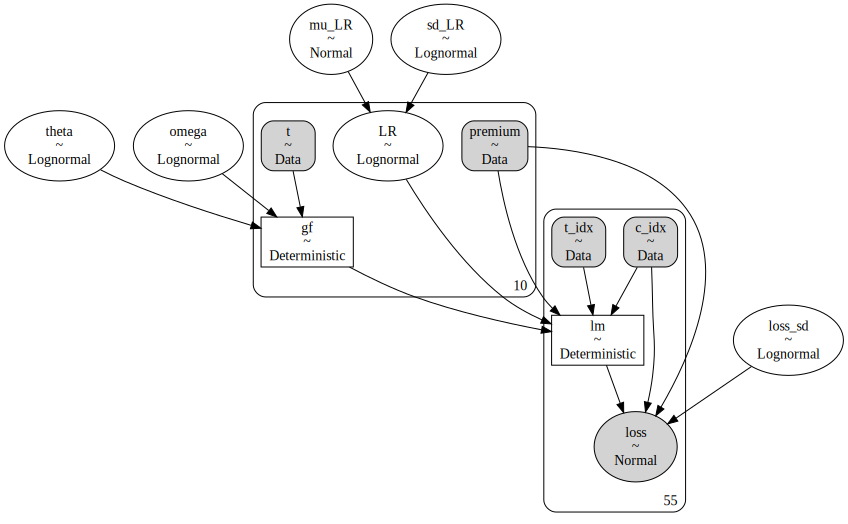

In [6]:
g = pm.model_to_graphviz(basic_model)
g

In [9]:
usetable[['grcode','grname','acc_year','dev_year','dev_lag','premium','cum_loss','loss_ratio']].head()

,grcode,grname,acc_year,dev_year,dev_lag,premium,cum_loss,loss_ratio
0,43,IDS Property Cas Ins Co,1988,1988,1,957,133,0.138976
1,43,IDS Property Cas Ins Co,1988,1989,2,957,333,0.347962
2,43,IDS Property Cas Ins Co,1988,1990,3,957,431,0.450366
3,43,IDS Property Cas Ins Co,1988,1991,4,957,570,0.595611
4,43,IDS Property Cas Ins Co,1988,1992,5,957,615,0.642633


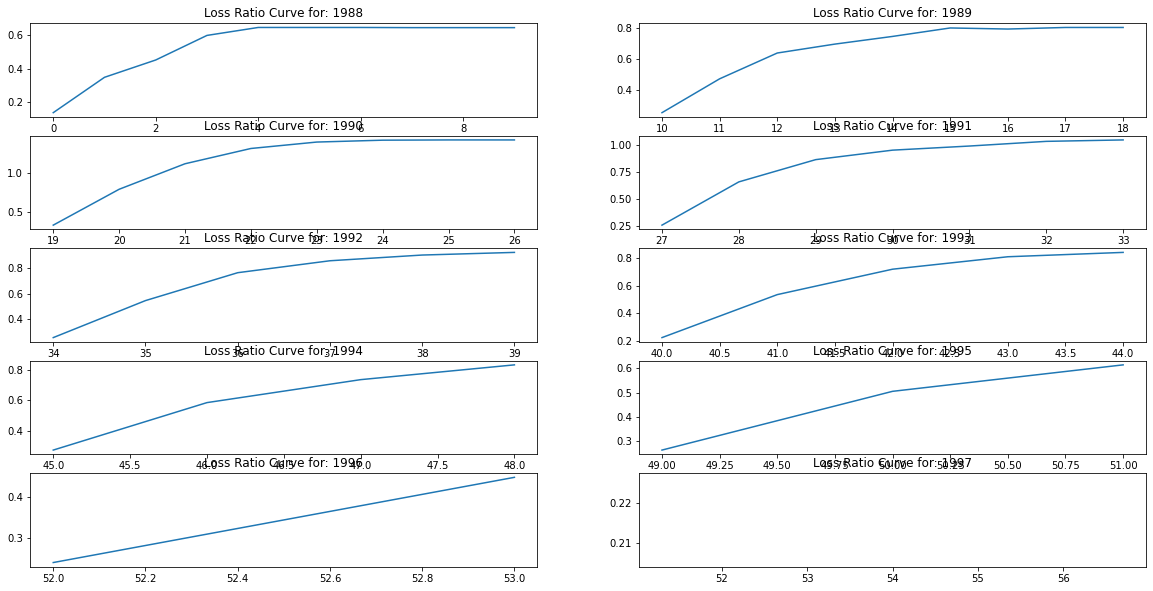

In [22]:
years = usetable['acc_year'].unique()
fig, axs = plt.subplots((int(len(years)/2)), 2, figsize=(20,10))
axs = axs.flatten()
for ax, year in zip(axs, years):
    usetable[usetable['acc_year'] == year]['loss_ratio'].plot(ax=ax, title="Loss Ratio Curve for: " + str(year))

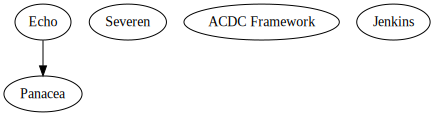

In [37]:
from graphviz import Digraph, Graph

# Packages
p = Digraph()
p.node('Echo', 'Echo')
p.node('Severen', 'Severen')
p.node('Panacea', 'Panacea')


## Frameworks
f = Digraph()
f.node('ACDC', 'ACDC Framework')
f.node('Jenkins', 'Jenkins')

p.edge('Echo', 'Panacea')

p.subgraph(f)

f.edge('Jenkins', 'Echo')
p

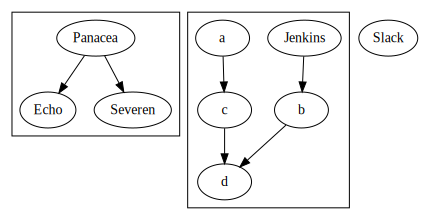

In [54]:
g = Digraph('G', filename='cluster_edge.gv')
g.attr(compound='true')
g.node('e', 'Echo')
g.node('s', 'Severen')
g.node('p', 'Panacea')
g.node('j', 'Jenkins')
g.node('slack', 'Slack')


with g.subgraph(name='cluster0') as c:
    c.edges(['jb', 'ac', 'bd', 'cd'])

with g.subgraph(name='cluster1') as c:
    c.edges(['ps', 'pe'])


g

In [55]:
idata

Inference data with groups:
	> posterior
	> posterior_predictive
	> log_likelihood
	> sample_stats
	> prior
	> prior_predictive
	> observed_data
	> constant_data

array([<AxesSubplot:xlabel='loss'>], dtype=object)

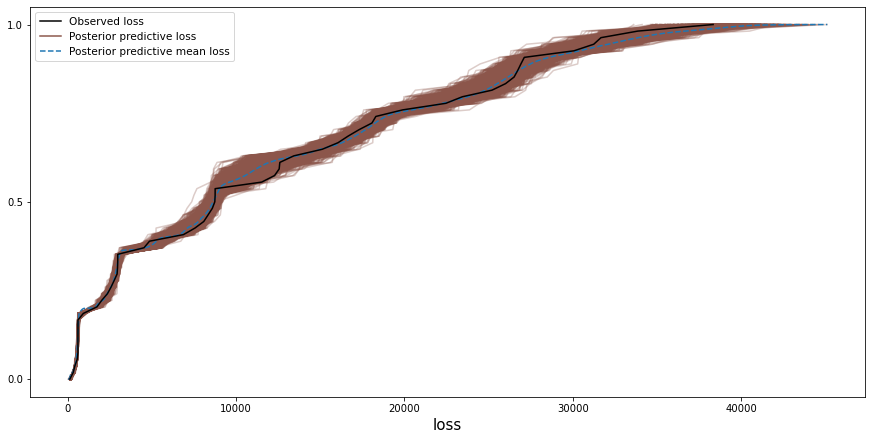

In [57]:
az.plot_ppc(idata, alpha=0.3, kind="cumulative", figsize=(12, 6), textsize=14)

/Users/nathanielforde/anaconda/envs/examined_algorithms/lib/python3.6/site-packages/arviz/stats/stats.py:151: UserWarning: 
The scale is now log by default. Use 'scale' argument or 'stats.ic_scale' rcParam if you rely on a specific value.
A higher log-score (or a lower deviance) indicates a model with better predictive accuracy.
  "\nThe scale is now log by default. Use 'scale' argument or "
/Users/nathanielforde/anaconda/envs/examined_algorithms/lib/python3.6/site-packages/arviz/stats/stats.py:683: UserWarning: Estimated shape parameter of Pareto distribution is greater than 0.7 for one or more samples. You should consider using a more robust model, this is because importance sampling is less likely to work well if the marginal posterior and LOO posterior are very different. This is more likely to happen with a non-robust model and highly influential observations.
  "Estimated shape parameter of Pareto distribution is greater than 0.7 for "
/Users/nathanielforde/anaconda/envs/examined

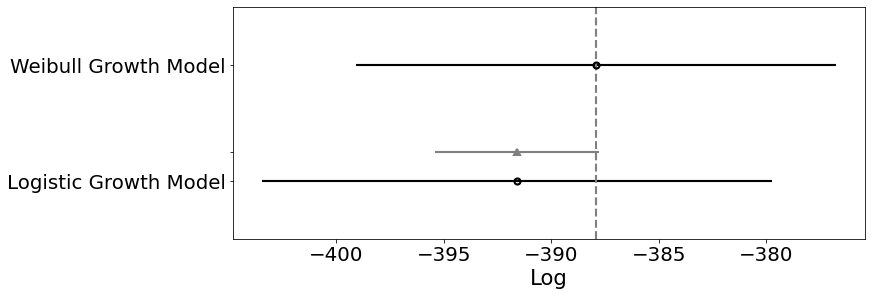

In [61]:
model_compare = az.compare(
    {
        "Logistic Growth Model": logistic_idata,
        "Weibull Growth Model": weibull_idata,
    }
)
az.plot_compare(model_compare, figsize=(12, 4), insample_dev=False)

plt.show()

In [60]:
az.plot_trace(logistic_idata, var_names=["gf", "LR"], circ_var_names=["LR"])

TypeError: plot_trace() got an unexpected keyword argument 'circ_var_names'

In [94]:
logistic_model.logp

In [100]:
logp = logistic_model.logp
lnp = np.array([logp(logistic_trace.point(i,chain=c)) for c in logistic_trace.chains for i in range(len(logistic_trace))])

0       0.0
1       0.0
2       0.0
3       0.0
4       0.0
       ... 
1995    0.0
1996    0.0
1997    0.0
1998    0.0
1999    0.0
Length: 2000, dtype: float64

In [106]:
logistic_trace.report.log_marginal_likelihood

AttributeError: 'SamplerReport' object has no attribute 'log_marginal_likelihood'

In [107]:
model_compare

,rank,loo,p_loo,d_loo,weight,se,dse,warning,loo_scale
Weibull Growth Model,0,-387.915,10.6734,0,0.811983,11.1849,0,True,log
Logistic Growth Model,1,-391.599,10.2344,3.68346,0.188017,11.874,3.81681,True,log
